In [2]:
import nltk
import matplotlib as plt
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import numpy as np
from nltk.stem import WordNetLemmatizer
import json
import pickle
import random
lemmatizer=WordNetLemmatizer()

In [4]:
words=[]
classes=[]
documents=[]
ignore_words=[ '?', '@', '!', ',', '.', ';', ':', '#', '$', '%', '^', '&', '*', '(', ')', '[', ']', '{', '}', '...',]

In [5]:
dataset=open('intents.json').read()
intents=json.loads(dataset)
print(intents)


{'intents': [{'tag': 'Cuts', 'patterns': ['What to do if Cuts?', 'How to cure Cuts?', 'Which medicine to apply for Cuts?', 'what to apply on cuts?', 'Cuts'], 'responses': ['Wash the cut properly to prevent infection and stop the bleeding by applying pressure for 1-2minutes until bleeding stops. Apply Petroleum Jelly to make sure that the wound is moist for quick healing. Finally cover the cut with a sterile bandage. Pain relievers such as acetaminophen can be applied.'], 'context_set': ''}, {'tag': 'greeting', 'patterns': ['Hi', 'How are you', 'Is anyone there?', 'Hello', 'Whats up'], 'responses': ['Hi , i am your paramedic assistant', 'Hello what can i do for you'], 'context_set': ''}, {'tag': 'goodbye', 'patterns': ['cya', 'See you later', 'Goodbye', 'I am Leaving', 'Have a Good day', 'bye'], 'responses': ['Sad to see you go :(', 'Talk to you later', 'Goodbye!'], 'context_set': ''}, {'tag': 'Abrasions', 'patterns': ['how do you treat abrasions?', 'Do Abrasions cause scars?', 'Abrasio

Extracting the data from json file

In [6]:
for intent in intents['intents']:
    for pattern in intent['patterns']:
        word_token=nltk.word_tokenize(pattern)
        words.extend(word_token)
        
        documents.append((word_token,intent['tag']))
        
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

words=[lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_words] 
words=sorted(list(set(words)))
classes=sorted(list(set(classes)))

print("Words:",words)
print("Classes:",classes)
print("Documents:",documents)
    

Words: ['a', 'abdonominal', 'abrasion', 'allergy', 'am', 'an', 'animal', 'anyone', 'apply', 'are', 'better', 'bit', 'bite', 'bitten', 'bleed', 'bleeding', 'blocked', 'bring', 'broken', 'bruise', 'burn', 'by', 'bye', 'cause', 'chemical', 'choke', 'choked', 'choking', 'cold', 'congestion', 'cough', 'cpr', 'cream', 'cure', 'cut', 'cya', 'day', 'diagnose', 'diarrhea', 'do', 'doe', 'dog', 'drowned', 'drowning', 'due', 'exhausted', 'exhaustion', 'eye', 'faint', 'fainting', 'feel', 'fever', 'for', 'fracture', 'frost', 'gas', 'gastrointestinal', 'get', 'give', 'good', 'goodbye', 'got', 'have', 'head', 'headache', 'heat', 'hello', 'help', 'hi', 'how', 'i', 'ice', 'if', 'in', 'injured', 'injury', 'insect', 'is', 'last', 'later', 'leaving', 'like', 'long', 'me', 'medicine', 'mild', 'monekey', 'monkey', 'muscle', 'my', 'nasal', 'nose', 'of', 'on', 'or', 'pain', 'person', 'poison', 'poisoned', 'poisoning', 'problem', 'pulled', 'rash', 'rectal', 'remove', 'rid', 'scar', 'see', 'seizure', 'skin', 'sn

In [7]:
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

Training Process


In [8]:
training=[]
output_empty=[0]*len(classes)

for document in documents:
    bag_of_words=[]
    
    pattern_words=document[0]
    pattern_words=[lemmatizer.lemmatize(w.lower()) for w in pattern_words]
    
    for w in words:
        if w in pattern_words:
            bag_of_words.append(1)
        else:
            bag_of_words.append(0)
    
    output_row=list(output_empty)
    output_row[classes.index(document[1])]=1
    
    training.append([bag_of_words,output_row])
    
random.shuffle(training)
training=np.array(training,dtype=object)


In [9]:
x_train=training[:,0]
y_train=training[:,1]


In [10]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,BatchNormalization,LeakyReLU
from keras.optimizers import SGD
from keras import initializers

#Initialize the model
ann=Sequential()

#Input layer
ann.add(Dense(128,activation='relu',input_shape=(len(x_train[0]),),kernel_initializer=initializers.he_normal()))
ann.add(LeakyReLU(alpha=0.01))
ann.add(BatchNormalization())
ann.add(Dropout(0.5))

#Hidden layer
ann.add(Dense(64, kernel_initializer=initializers.he_normal()))
ann.add(LeakyReLU(alpha=0.01))
ann.add(BatchNormalization())
ann.add(Dropout(0.5))

#output layer
ann.add(Dense(len(y_train[0]),activation='softmax'))

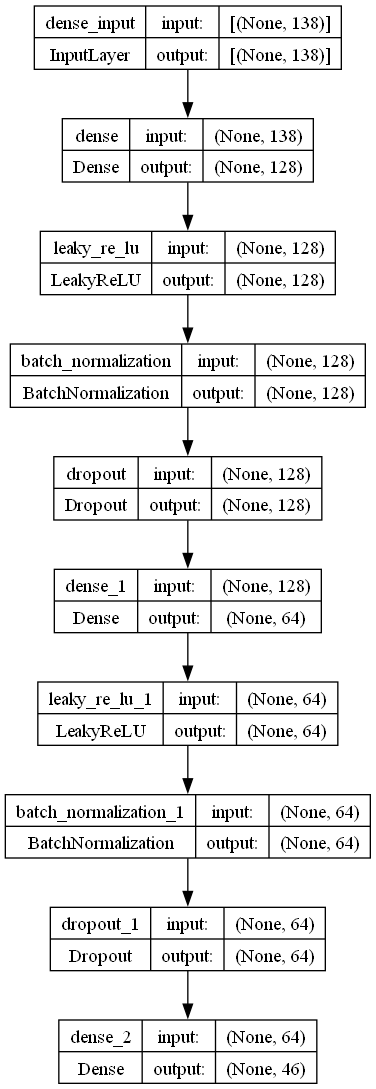

In [11]:
#Visualize the ANN Model
from keras.utils import plot_model

plot_model(ann, to_file='model_visualization.png', show_shapes=True, show_layer_names=True)

In [12]:
sgd=SGD(learning_rate=0.01, weight_decay=1e-6,momentum=0.9,nesterov=True)
ann.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=["accuracy"])